In [698]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from scipy import stats
import seaborn as sns
from IPython.display import display, Markdown

In [699]:
debug=False

def my_print(str):
    if (debug):
        print(str)

def make_title_from_folder_path(path):
    folder_segments = path.split('/')
    seq_or_con = folder_segments[1]
    rand_or_not = folder_segments[2]
    latency = int(folder_segments[3][:3])/10
    jitter = int(folder_segments[3][3:])/10

    return f'{seq_or_con} {rand_or_not}, latency: {latency}ms, jitter: {jitter}ms'.capitalize()

# https://stackoverflow.com/a/40347279
def fast_scandir(dirname):
    subfolders= [f.path for f in os.scandir(dirname) if f.is_dir()]
    for dirname in list(subfolders):
        subfolders.extend(fast_scandir(dirname))
    return subfolders

def get_clean_data(folder, name, batch_qty):
    input_df = pd.read_csv(f'{folder}/{name}.csv', header=None, nrows=batch_qty*5)

    before_len = len(input_df)
    
    my_print("Cleaning " + name + ".csv (" + str(before_len) + " rows)")
    
    allowed_http_codes = [200, 302]
    
    input_df = input_df[(input_df[1].isin(allowed_http_codes)) & (input_df[2].isin(allowed_http_codes))]

    my_print(str(before_len - len(input_df)) + " rows with unexpected http codes")

    before_len = len(input_df)
    input_df = input_df[(np.abs(stats.zscore(input_df[0])) < 3)]
    
    my_print(str(before_len - len(input_df)) + " rows with outliers")
    
    return input_df[0]

# NOTE no outlier removal etc - here we are trying to see how effective the most naive implemetantion would be. 
# I.e. how likely it is that an attack is accurate given a small sample of salvos (i.e. 5 pairs as the entire attack).  
def overall_result(folder, location, type, batch_qty):
    filename = f'{location}_{type}_winners.csv'
    
    input_df = pd.read_csv(f'{folder}/{filename}', header=None, nrows=batch_qty)
    total_qty = len(input_df)
    suspect_email_exists_qty = len(input_df[input_df[0] == 0])

    pct = (suspect_email_exists_qty / total_qty) * 100

    summary_section = f'{suspect_email_exists_qty} of {total_qty} ({pct}%)'
    
    my_print(f'{summary_section} results indicate a user exists with the given email')
    display(Markdown(f'**{make_title_from_folder_path(folder)} - {type.title()}**'))
    display(Markdown(summary_section))
# Locations: local, remote
# Types: attack, control
def analyse_result_folder(folder, locations=["local"], types=["attack", "control"], batch_qty=50):
    df = pd.DataFrame()

    folder = f'completed_results/{folder}'
    
    for type in types:
        for location in locations:
            my_print(f'\n{folder} {location} {type}') 
            
            name = f'{location}_{type}_detail'
            
            df[name] = get_clean_data(folder, name, batch_qty)

            overall_result(folder, location, type, batch_qty)

    xlim=5e8

    ax = df.plot.kde(
        # bw_method=0.1,
        title=make_title_from_folder_path(folder),
        figsize=(10,3), 
        color=['red', 'olivedrab', 'goldenrod', 'mediumseagreen'],
        xlim=(-xlim, xlim)
    )
    
    ax.legend(['Attack', 'Control'], loc='upper right')
    ax.set_xlabel('Pair-wise response time diff (ns.)', fontsize=10)




In [700]:
# While the above kde chart is useful for improving our mental model of how the attack works, all a real attacker really needs to know is 
# whether responses typically arrived at about the same time. 
# Our analysis suggests that under good network conditions only one batch of 5 pairs is required, even in the remote (over the internet) context

# Suprised that the spread is wider for local vs. remote. Perhaps something to do with virtualisation, or some other detail of the specific
# deployment of the contrived target app. What's cool about this attack though, is that we don't care about that kind of detail at all! 
# All we care about is "did the response pairs arrive back at about the same time?". 

# As you would expect, remote probes take longer in general, vs. local


# What is most interesting in these results is how obvious the difference between control and attack is. 
# This suggests that any single indicator in the attack data of the target user existing is probably good enough
# Itis very likely that the first salvo will be enough, and if not, only 2 or 3 should be required nuder most circumstances. 

**Sequential non-randomised, latency: 0.0ms, jitter: 0.0ms - Attack**

29 of 50 (57.99999999999999%)

**Sequential non-randomised, latency: 0.0ms, jitter: 0.0ms - Control**

0 of 50 (0.0%)

**Concurrent non-randomised, latency: 0.0ms, jitter: 0.0ms - Attack**

25 of 50 (50.0%)

**Concurrent non-randomised, latency: 0.0ms, jitter: 0.0ms - Control**

0 of 50 (0.0%)

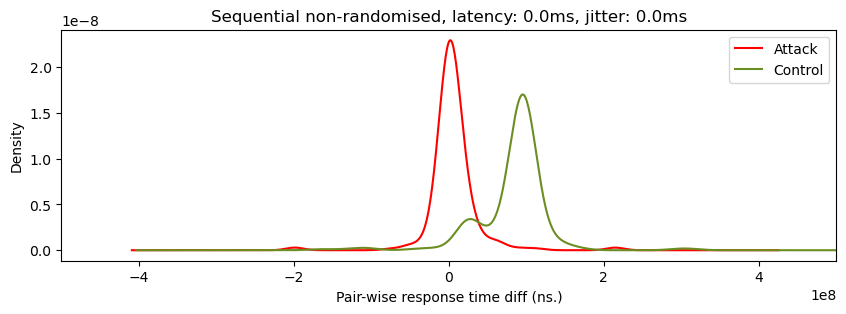

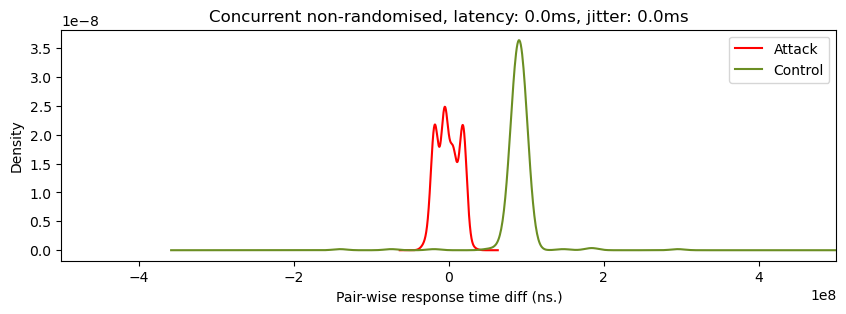

In [701]:
analyse_result_folder('sequential/non-randomised/000000')
analyse_result_folder('concurrent/non-randomised/000000')

**Sequential randomised, latency: 20.0ms, jitter: 10.0ms - Attack**

26 of 50 (52.0%)

**Sequential randomised, latency: 20.0ms, jitter: 10.0ms - Control**

19 of 50 (38.0%)

**Concurrent randomised, latency: 20.0ms, jitter: 10.0ms - Attack**

22 of 50 (44.0%)

**Concurrent randomised, latency: 20.0ms, jitter: 10.0ms - Control**

2 of 50 (4.0%)

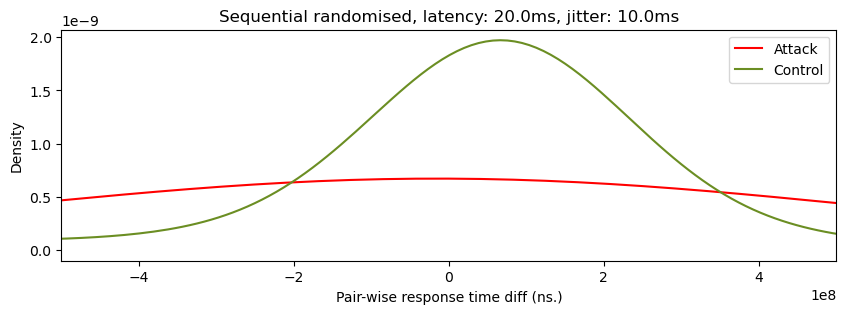

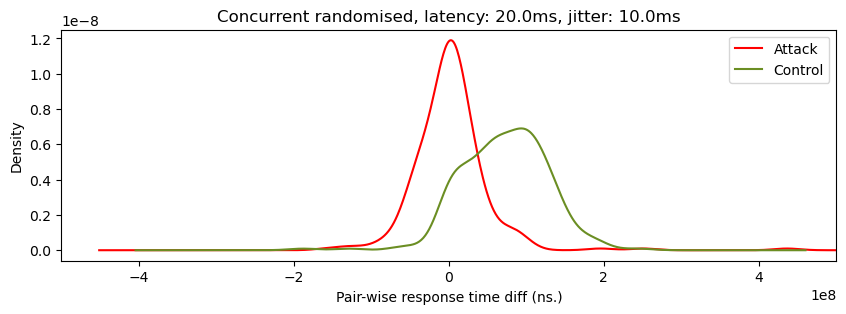

In [702]:
analyse_result_folder('sequential/randomised/200100')
analyse_result_folder('concurrent/randomised/200100')



**Sequential randomised, latency: 40.0ms, jitter: 20.0ms - Attack**

27 of 50 (54.0%)

**Sequential randomised, latency: 40.0ms, jitter: 20.0ms - Control**

29 of 50 (57.99999999999999%)

**Concurrent randomised, latency: 40.0ms, jitter: 20.0ms - Attack**

25 of 50 (50.0%)

**Concurrent randomised, latency: 40.0ms, jitter: 20.0ms - Control**

8 of 50 (16.0%)

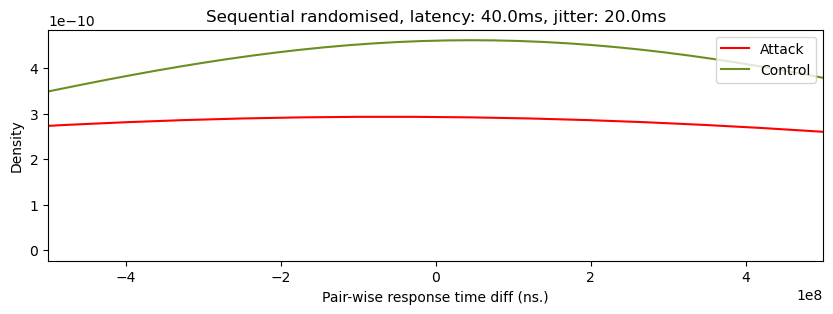

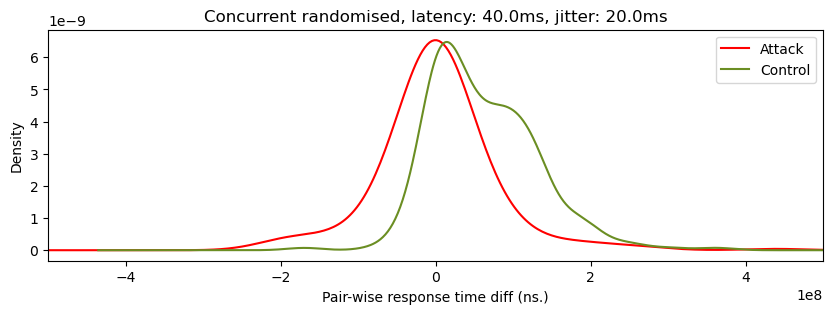

In [705]:
analyse_result_folder('sequential/randomised/400200')
analyse_result_folder('concurrent/randomised/400200')

**Concurrent non-randomised, latency: 5.0ms, jitter: 2.5ms - Attack**

26 of 48 (54.166666666666664%)

**Concurrent non-randomised, latency: 5.0ms, jitter: 2.5ms - Control**

0 of 50 (0.0%)

**Concurrent non-randomised, latency: 10.0ms, jitter: 5.0ms - Attack**

23 of 50 (46.0%)

**Concurrent non-randomised, latency: 10.0ms, jitter: 5.0ms - Control**

2 of 50 (4.0%)

**Concurrent non-randomised, latency: 20.0ms, jitter: 10.0ms - Attack**

37 of 50 (74.0%)

**Concurrent non-randomised, latency: 20.0ms, jitter: 10.0ms - Control**

21 of 50 (42.0%)

**Concurrent non-randomised, latency: 40.0ms, jitter: 20.0ms - Attack**

33 of 50 (66.0%)

**Concurrent non-randomised, latency: 40.0ms, jitter: 20.0ms - Control**

20 of 49 (40.816326530612244%)

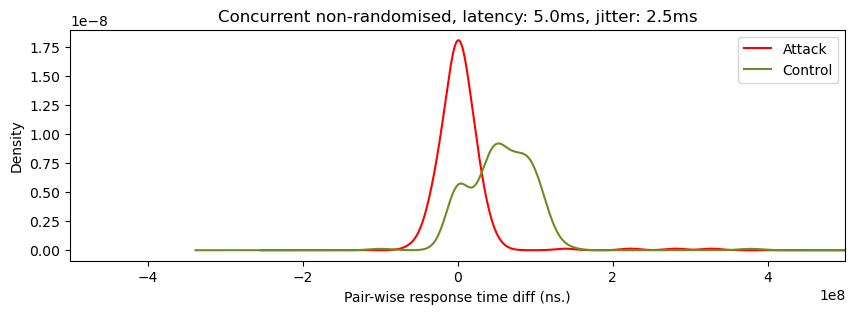

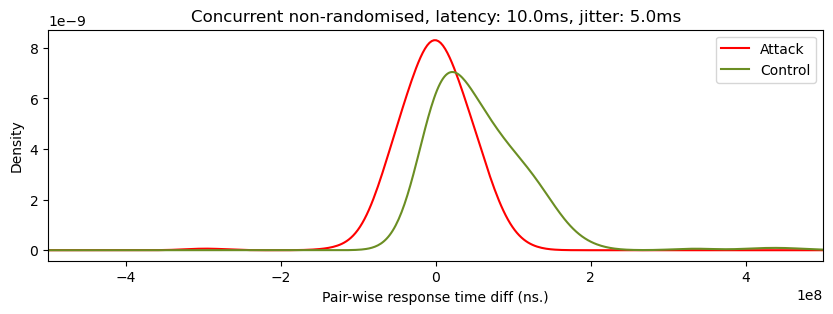

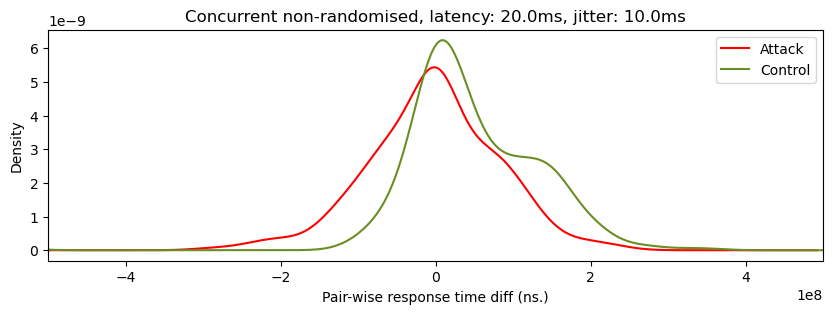

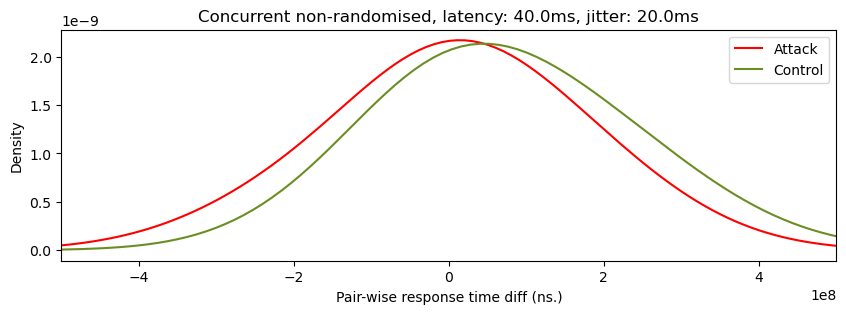

In [704]:
analyse_result_folder('concurrent/non-randomised/050025')
analyse_result_folder('concurrent/non-randomised/100050')
analyse_result_folder('concurrent/non-randomised/200100')
analyse_result_folder('concurrent/non-randomised/400200')